In [16]:
# Import our dependencies
import pandas as pd
import numpy as np
import math
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs('checkpoints/', exist_ok = True)
checkpoint_path = 'checkpoints/weights.{epoch:02d}.hdf5'
data = pd.read_csv('coin_Bitcoin.csv')

In [49]:
def run_lstm_model (data, target, drop = [], thresholds = [], window = 7,
        input_node = { 'units': 10, 'activation': 'relu' },
        hidden_nodes = [
            { 'units': 5, 'activation': 'relu' }
        ],
        output_node = { 'units': 1, 'activation': 'relu' },
        optimizer = 'adam',
        epochs = 100, save_path = '', percent = .75, verbose = 0):
    """
    Processes data, creates a neuro network, trains, and tests it.  Returns the trained model.
    data: target and features values in a data frame
    target: the name of the y col in data
    drop: cols to drop from the data
    thresholds: an array of obects with properties 'col' and 'threshold'
        col is the column to bin
        threshold is teh value below which all vals should be binned into other
    target: the name of the target col
    input_node: an object with properties 'units' and 'activation'
    hidden_nodes: an array of objects with properties 'units' and 'activation'
    output_node: an object with properties 'units' and 'activation'
        units is an int
        activation is a string in: relu, leaky_relu, tanh, sigmoid
    optimizer: a string in: adadelta, adagrad, adam, adamax, ftrl, optimiser, rmsprop, sgd
    epochs: how long to train the model
    save_path: where to save epoch weights; an empty string tells the code to not save epochs 
    seed: an int to seed the train/test split on
    verbose: an int to set how much data the model outputs while running
    """
    
    # clone data
    data_clone = data.copy()
    
    # clean data
    data_clone = clean_data(data_clone, drop, thresholds)
    
    #get train/test data and make model
    X_train, X_test, y_train, y_test = get_target_and_features(data_clone, target, percent, window)
    print(X_train)
    print(y_test)
    
    model = create_model(X_train, input_node, hidden_nodes, output_node, optimizer)
    
    #run and evaluate model; return model
    return evaluate(model, X_train, X_test, y_train, y_test, epochs, save_path, verbose)
    


In [3]:
def clean_data(data, drop, thresholds):
    # drop columns
    data = data.drop(drop, 1)
    
    # compress large sets of data
    for threshold in thresholds:
        data = compress(data, threshold['col'], threshold['threshold'])
        
    ####TODO
    # We need code to handle the date data appropriately
    
    #replace cats as dummys
    return encode(data)

In [4]:
def compress (data, col, threshold):
    
    # get vals to replace
    counts = data[col].value_counts()
    replace = list(counts[counts < threshold].index)
    
    #replace the values and return
    for rep in replace:
        data[col] = data[col].replace(rep, 'Other')
    return data
    

In [5]:
def encode(data):    
    # get cats     
    cat = data.dtypes[data.dtypes == 'object'].index.tolist()
    
    # make encoder and encode
    enc = OneHotEncoder(sparse = False)
    encode = pd.DataFrame(enc.fit_transform(data[cat]))
    encode.columns = enc.get_feature_names(cat)    
    
    # return new df
    return data.merge(encode, left_index = True, right_index = True).drop(cat, 1)


In [54]:
def get_target_and_features(data, target, percent, window):
    # Split our preprocessed data into our features and target arrays
    y = data[target].values
    X = data.drop([target], 1).values

    # Split the preprocessed data into a training and testing dataset
    cutoff = math.floor(len(X) * percent)
    X_train = X[:cutoff]
    X_test = X[cutoff:]
    y_train = y[:cutoff]
    y_test = y[cutoff:]
    
    # Create a StandardScaler instances
    scaler = StandardScaler()

    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # create window increments     
    X_train, y_train = set_window(X_train_scaled, y_train, window)
    X_test, y_test = set_window(X_test_scaled, y_test, window)
   
    
    return X_train, X_test, y_train, y_test

In [7]:
def set_window(X, y, window):
    #Add window
    Xin = []
    next_y = []
    for i in range(window, len(X)):
        try:
            next_y.append(y[i])
            Xin.append(X[i-window:i])
        # for the cases where there is no future y, just drop the data.         
        except:
            pass
        
    # Reshape data to format for LSTM
    X, y = np.array(Xin), np.array(next_y)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    return X, y
    

In [51]:
def create_model(X_train, input_node, hidden_nodes, output_node, optimizer):

    # get the input node number
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # create model
    nn = tf.keras.models.Sequential()
    
    #add layers
    #input
    nn.add(tf.keras.layers.LSTM(units = input_node['units'], input_shape = input_shape,
                                 activation = input_node['activation'], return_sequences = True))
    nn.add(tf.keras.layers.Dropout(.2))
        
    #hidden
    for ind, node in enumerate(hidden_nodes):
        if ind == len(hidden_nodes) - 1:
            nn.add(tf.keras.layers.LSTM(units = node['units'], activation = node['activation']))
        else:
            nn.add(tf.keras.layers.LSTM(units = node['units'], activation = node['activation'],
                                        return_sequences = True))
        nn.add(tf.keras.layers.Dropout(.2))
    
    #output
    nn.add(tf.keras.layers.Dense(units = output_node['units']))

    #compile and return
    nn.compile(loss = 'mse', optimizer = optimizer, metrics = ['accuracy'])
    return nn


In [46]:
def create_callback (path, verbose):
    return ModelCheckpoint(
        filepath = path,
        verbose = verbose,
        save_weights_only = True,
        save_freq = 'epoch')

In [47]:
def evaluate(model, X_train, X_test, y_train, y_test, epochs, save_path, verbose):
    # it either wiith callpaths to save epochs or without
    if save_path != '':
        fit_model = model.fit(X_train, y_train, epochs = epochs, verbose = verbose,
                              callbacks = [create_callback(save_path, verbose)])
    else:
        fit_model = model.fit(X_train, y_train, epochs = epochs, verbose = verbose)
    
    #give feedback on model performance
    model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose = verbose)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    
    predictions = model.predict(X_test)
    
    #return the model
    return model, fit_model, predictions, y_test

In [55]:
model, history, predictions, actual = run_lstm_model(data, 'Close',
                                                     drop = ['Name', 'Symbol', 'SNo', 'Date'],
                                                    verbose = 1)

[[[-0.69490297 -0.70877389 -0.7019719  -0.5108287  -0.69780732]
  [-0.69506119 -0.70875856 -0.69916602 -0.5108287  -0.69885171]
  [-0.69705732 -0.71682834 -0.70063415 -0.5108287  -0.7030299 ]
  ...
  [-0.70606316 -0.72559998 -0.71025035 -0.5108287  -0.70667867]
  [-0.70411466 -0.72149306 -0.7126434  -0.5108287  -0.70386325]
  [-0.7030372  -0.71700519 -0.70829775 -0.5108287  -0.70320572]]

 [[-0.69506119 -0.70875856 -0.69916602 -0.5108287  -0.69885171]
  [-0.69705732 -0.71682834 -0.70063415 -0.5108287  -0.7030299 ]
  [-0.70110912 -0.72155991 -0.70727594 -0.5108287  -0.70526476]
  ...
  [-0.70411466 -0.72149306 -0.7126434  -0.5108287  -0.70386325]
  [-0.7030372  -0.71700519 -0.70829775 -0.5108287  -0.70320572]
  [-0.7013748  -0.71715935 -0.70739339 -0.5108287  -0.70388541]]

 [[-0.69705732 -0.71682834 -0.70063415 -0.5108287  -0.7030299 ]
  [-0.70110912 -0.72155991 -0.70727594 -0.5108287  -0.70526476]
  [-0.70606316 -0.72559998 -0.71025035 -0.5108287  -0.70667867]
  ...
  [-0.7030372  -0.

70/70 [==============================] - 2s 4ms/step - loss: 18044838.0000 - accuracy: 0.0000e+00
Epoch 2/100
70/70 [==============================] - 0s 4ms/step - loss: 14310078.0000 - accuracy: 0.0000e+00
Epoch 3/100
70/70 [==============================] - 0s 4ms/step - loss: 3596823.7500 - accuracy: 0.0000e+00
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 2792565.7500 - accuracy: 0.0000e+00
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 2182270.2500 - accuracy: 0.0000e+00
Epoch 6/100
70/70 [==============================] - 0s 4ms/step - loss: 2139645.0000 - accuracy: 0.0000e+00
Epoch 7/100
70/70 [==============================] - 0s 4ms/step - loss: 2025396.3750 - accuracy: 0.0000e+00
Epoch 8/100
70/70 [==============================] - 0s 4ms/step - loss: 2147328.2500 - accuracy: 0.0000e+00
Epoch 9/100
70/70 [==============================] - 0s 3ms/step - loss: 2144935.7500 - accuracy: 0.0000e+00
Epoch 10/100
70/70 [=========

70/70 [==============================] - 0s 5ms/step - loss: 1633966.3750 - accuracy: 0.0000e+00
Epoch 76/100
70/70 [==============================] - 0s 5ms/step - loss: 1660819.3750 - accuracy: 0.0000e+00
Epoch 77/100
70/70 [==============================] - 0s 5ms/step - loss: 1799397.8750 - accuracy: 0.0000e+00
Epoch 78/100
70/70 [==============================] - 0s 5ms/step - loss: 1617093.2500 - accuracy: 0.0000e+00
Epoch 79/100
70/70 [==============================] - 0s 5ms/step - loss: 1749057.2500 - accuracy: 0.0000e+00
Epoch 80/100
70/70 [==============================] - 0s 5ms/step - loss: 1796695.8750 - accuracy: 0.0000e+00
Epoch 81/100
70/70 [==============================] - 0s 5ms/step - loss: 1878935.7500 - accuracy: 0.0000e+00
Epoch 82/100
70/70 [==============================] - 0s 5ms/step - loss: 1663615.7500 - accuracy: 0.0000e+00
Epoch 83/100
70/70 [==============================] - 0s 5ms/step - loss: 1984582.1250 - accuracy: 0.0000e+00
Epoch 84/100
70/70 [===

D:\Programs\Python\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



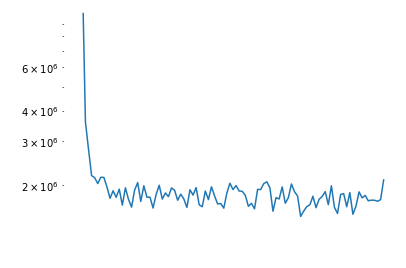

In [94]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
plt.ylabel('loss'); plt.xlabel('epoch')
plt.semilogy(history.history['loss'])

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.set_ylim(0, 10000000)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='both', colors='white')
plt.show()


In [103]:
import plotly.express as plt
import plotly.graph_objs as go

In [109]:
plt.scatter(x = predictions.reshape(741), y = actual,  labels={
                     "x": "prediction",
                     "y": "actual",
                 }, trendline = 'ols')

In [126]:
import plotly.graph_objects as go

df = pd.DataFrame({'Predictions': predictions.reshape(741),
                   'Actual': actual})
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['Predictions'], y=df['Actual'],
                    mode='markers',
                    name='Prediction vs. actual'))
fig.add_trace(go.Scatter(x=[0, 60000], y=[0, 60000],
                    mode='lines+markers',
                    name='x = 1'))

fig.layout = dict(plot_bgcolor='white',
              xaxis=dict(title='Predictions'),
              yaxis=dict(title='Actual'))
fig.show()

In [127]:
data

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11
